### Multiclass Support Vector Machines
In this exercise you will:
- implement a fully-vectorized loss function for the mulri-class SVM
- implement the fully-vectorized expression for its analytic gradient
- check your implementation using numerical gradient
- use a validation set to tune the learning rate and regularization strength
- optimize the loss function with SGD
- visualize the final learned parameters

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### CIFAR-10 Data Loading and Preprocessing
Open up a terminal window and navigate to the datasets folder inside the hw3 folder. Run the get_datasets.sh script. On my Mac, I just type in ./get_datasets.sh at the shell prompt. A new folder called cifar_10_batches_py will be created and it will contain 50000 labeled images for training and  10000 labeled images for testing. The function further partitions the  50000 training images into a train set and a validation set for selection of hyperparameters. We have provided a function to read this data in **data_utils.py**. Each image is a  32×32
array of RGB triples. It is preprocessed by subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size 3072 (i.e.,  32×32×3). Then a 1 is appended to the front of that vector to handle the intercept term. So the training set is a numpy matrix of size  49000×3073, the validation set is a matrix of size  1000×3073 and the set-aside test set is of size  10000×3073. We also have a random sample of 500 images from the training data to serve as a development set or dev set to test our gradient and loss function implementations.

In [2]:
import data_utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_dev, y_dev, X_test, y_test = data_utils.get_CIFAR10_data()

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (10000, 3072)
dev data shape:  (500, 3072)
Training data shape with bias term:  (49000, 3073)
Validation data shape with bias term:  (1000, 3073)
Test data shape with bias term:  (10000, 3073)
Devset data shape with bias term:  (500, 3073)


### SVM Classifier
Your code for this section will all be written inside **linear_svm.py**.
You will need to write the function **naive_loss_svm** which uses for loops to evaluate the multiclass SVM loss function.

In [3]:
# Evaluate the naive implementation of the loss we provided for you:
from linear_svm import svm_loss_naive
import time

# generate a random SVM coefficient matrix of small numbers
theta = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(theta, X_train, y_train, 0.00001)
print 'loss: %f' % (loss, )
print 'grad: ', grad

loss: 8.773679
grad:  [[ -1.49207451e+01  -5.83793845e+00   1.97377147e+00 ...,  -2.43624035e+00
   -1.31567216e+01  -3.19811739e+01]
 [ -2.56846004e+01  -2.16507044e+00   1.47261941e+00 ...,  -3.30295583e+00
   -2.37371494e+01  -3.61032589e+01]
 [ -4.62742599e+01  -3.36713432e+00   1.29815731e+01 ...,  -2.44237276e+00
   -4.21260970e+01  -4.61739444e+01]
 ..., 
 [ -9.98703812e+00  -5.12935033e+00  -9.76034872e-01 ...,  -7.92358689e+00
    1.33502372e+01  -3.88973750e+00]
 [ -2.34182917e+01  -1.15123981e+01   5.95394809e+00 ...,   7.06455926e+00
   -4.86005684e+00  -7.57285293e+00]
 [ -1.38775510e-02   1.40204085e-02  -1.63673478e-02 ...,   1.83672716e-04
    1.97551007e-02   1.93469382e-02]]


The grad returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function **svm_loss_naive**. You will find it helpful to interleave your new code inside the existing function.
To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you.

In [4]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at theta.
loss, grad = svm_loss_naive(theta, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda th: svm_loss_naive(th, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, theta, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(theta, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(theta, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, theta, grad)

numerical: 9.212352 analytic: 9.212352, relative error: 7.546143e-12
numerical: 22.634522 analytic: 22.634522, relative error: 1.305514e-12
numerical: 23.410386 analytic: 23.327394, relative error: 1.775689e-03
numerical: -9.126663 analytic: -9.162608, relative error: 1.965348e-03
numerical: -7.923327 analytic: -7.923327, relative error: 3.429149e-12
numerical: -4.317013 analytic: -4.317013, relative error: 2.355229e-11
numerical: 20.663710 analytic: 20.663710, relative error: 1.589150e-12
numerical: 21.707512 analytic: 21.731396, relative error: 5.498504e-04
numerical: -19.679126 analytic: -19.679126, relative error: 1.937552e-11
numerical: 24.465332 analytic: 24.465332, relative error: 5.919657e-12
numerical: -18.291308 analytic: -18.291308, relative error: 1.104729e-11
numerical: -32.425272 analytic: -32.425272, relative error: 6.214375e-12
numerical: 7.208143 analytic: 7.208143, relative error: 2.934251e-11
numerical: -0.387213 analytic: -0.387213, relative error: 9.738281e-10
nume

In [5]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 8.495501e+00 computed in 0.147627s
Vectorized loss: 8.495501e+00 computed in 0.019681s
difference: -0.000000


### Vectorized version of the gradient computation
Complete the implementation of svm_loss_vectorized, and compute the gradient
of the loss function in a vectorized way.



In [6]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(theta, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.168951s
Vectorized loss and gradient: computed in 0.017119s
difference: 0.000000


In [7]:
# In the file linear_classifier.py, we have implemented SGD in the function
# LinearClassifier.train() and you can run it with the code below.
from linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 808.094098
iteration 100 / 1500: loss 292.777139
iteration 200 / 1500: loss 109.379214
iteration 300 / 1500: loss 43.314723
iteration 400 / 1500: loss 19.124505
iteration 500 / 1500: loss 10.466854
iteration 600 / 1500: loss 7.202821
iteration 700 / 1500: loss 5.822265
iteration 800 / 1500: loss 5.365885
iteration 900 / 1500: loss 5.765709
iteration 1000 / 1500: loss 5.190440
iteration 1100 / 1500: loss 5.361436
iteration 1200 / 1500: loss 5.510537
iteration 1300 / 1500: loss 6.046542
iteration 1400 / 1500: loss 5.456021
That took 9.028862s


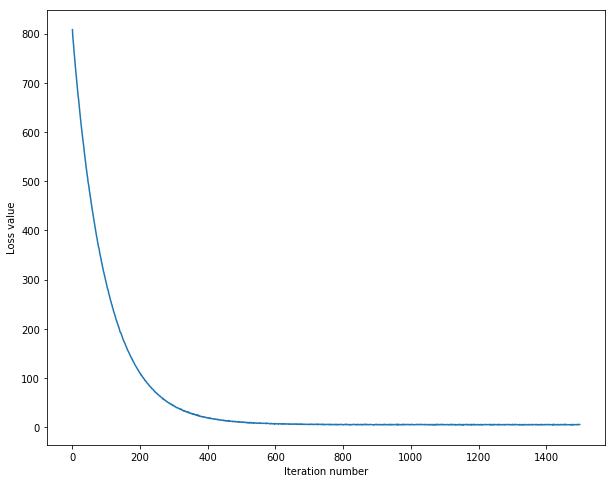

In [8]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Prediction with an SVM
Compute $\theta^T  x$ for a new example $x$ and pick the class with the highest score.

In [9]:
%%time
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.371122
validation accuracy: 0.380000
CPU times: user 1.25 s, sys: 58.5 ms, total: 1.31 s
Wall time: 359 ms


In [10]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.38 or higher on the validation set.

learning_rates = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [1e4, 5e4, 1e5, 5e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
#all possible combinations of hyperparameters
hyperparams_all = [(learning_rates[i], regularization_strengths[j]) 
               for i in range(len(learning_rates)) for j in range(len(regularization_strengths))]
for hyperparams in hyperparams_all:
    svm = LinearSVM()
    tic = time.time()
    loss_hist = svm.train(X_train, y_train, learning_rate=hyperparams[0], reg=hyperparams[1],
                          num_iters=1500, verbose=False)
    toc = time.time()
    print 'That took %fs' % (toc - tic)
    #store training and validation accuracy in the results dictionary
    y_train_pred = svm.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)
    results[hyperparams] = (training_accuracy, validation_accuracy)
    #store the best validation accuracy and the LinearSVM object that achieves this accuracy
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_svm = svm
    

    

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

That took 9.558936s
That took 9.181929s
That took 9.299697s
That took 9.044108s
That took 9.954859s
That took 9.752812s
That took 8.833545s
That took 9.211801s
That took 9.339850s
That took 9.382339s
That took 9.054968s
That took 9.162125s
That took 9.137741s
That took 9.809753s
That took 8.588135s
That took 9.620589s
That took 11.394637s
That took 9.623562s
That took 10.591218s
That took 11.990217s
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.222755 val accuracy: 0.243000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.250041 val accuracy: 0.243000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.302163 val accuracy: 0.322000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.326776 val accuracy: 0.340000
lr 5.000000e-08 reg 1.000000e+04 train accuracy: 0.316082 val accuracy: 0.326000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.371571 val accuracy: 0.370000
lr 5.000000e-08 reg 1.000000e+05 train accuracy: 0.360878 val accuracy: 0.360000
lr 5.000000e-08 reg 5.000000e+

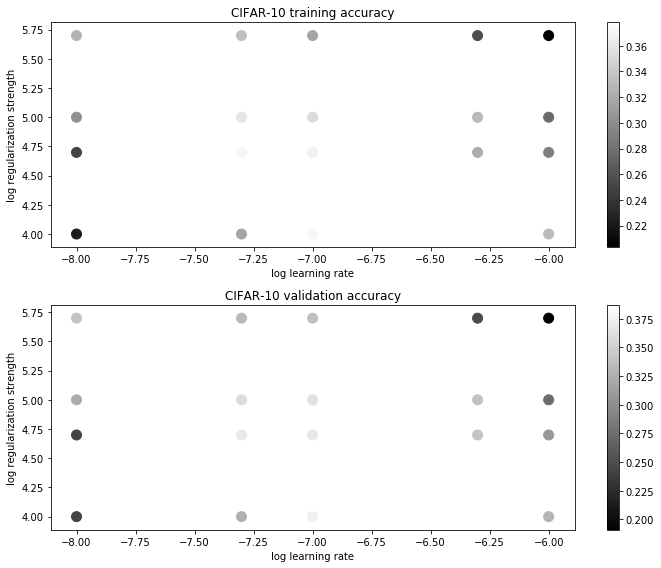

In [11]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.tight_layout()
plt.show()

In [12]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.365700


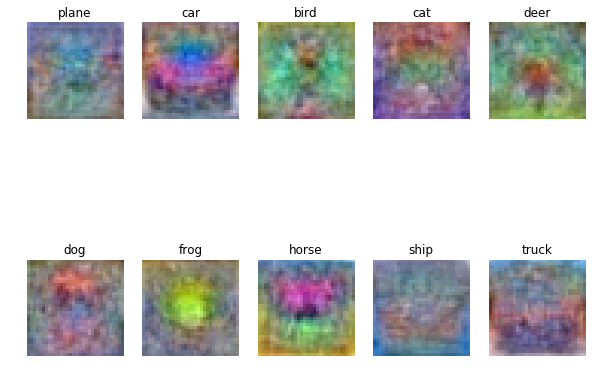

In [13]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.

theta = best_svm.theta[:-1,:] # strip out the bias
theta = theta.reshape(32, 32, 3, 10)
theta_min, theta_max = np.min(theta), np.max(theta)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[:, :, :, i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])